# Classification of Japanese Characters
## Alhagie Boye

For this lab we will be using KMNIST, which is a variation on the MNIST challenge.  This dataset has 10 Japanese characters from the Kuzushiji alphabet as seen below where the clean/standardized version is on the far left and handwritten variations are along the rows.  

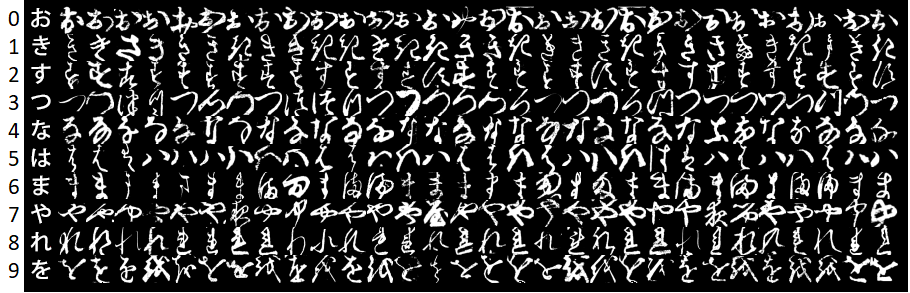

Kuzushiji is basically a cursive way to write Japanese characters, and more common characters actually have more variations than less common characters, which makes them harder to distinguish.  Translations made by experts have been established to take the handwritten characters and map them to modern, standardized versions.  For more, you can read about it here: https://www.tofugu.com/japanese/hentaigana-history-of-japanese-writing-system/

Wouldn't it be nice it this could be automated?  Let's start by loading some libraries...

Please note that this notebook must be run in a "Containerized" Jupyter Notebook on Rosie.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np              
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf
import time 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-11-08 21:07:39.951281: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 21:07:40.554706: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and Visualize Data

The data are organized into four files:

* Training images
* Training labels
* Testing images
* Testing labels

These can be loaded with `np.load()`.  This will return a dict-like object with a single key: `arr_0`.  The objects need to be closed when done.

Images are stored as a 3D array: image, rows, columns.

In [2]:
with np.load("/data/cs2300/L8/kmnist-train-imgs.npz") as training_images_fl:
    print(list(training_images_fl.keys()))
    print(training_images_fl["arr_0"].shape)
    training_images = training_images_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-test-imgs.npz") as testing_images_fl:
    print(list(testing_images_fl.keys()))
    print(testing_images_fl["arr_0"].shape)
    testing_images = testing_images_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-train-labels.npz") as training_labels_fl:
    print(list(training_labels_fl.keys()))
    print(training_labels_fl["arr_0"].shape)
    training_labels = training_labels_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-test-labels.npz") as testing_labels_fl:
    print(list(testing_labels_fl.keys()))
    print(testing_labels_fl["arr_0"].shape)
    testing_labels = testing_labels_fl["arr_0"]

['arr_0']
(60000, 28, 28)
['arr_0']
(10000, 28, 28)
['arr_0']
(60000,)
['arr_0']
(10000,)


Let's take a look at some of the characters.  

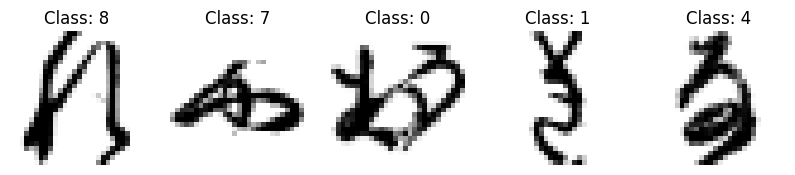

In [3]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
for ax, image, label in zip(axes, training_images, training_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Class: %i' % label)

## Set up Data for Deep Learning Models

In the following cell, we reshape and prepare the data for training.  The data needs to be in 4D tensors of shape (N,28,28,1) where N is the number of images.  Each image is 28x28 pixels.  Since they are greyscale, the images only have a single channel. 

The tensors represent the 256 possible gray colors using integer values (e.g., 0, 1, 2, …, 255).  You need to convert the tensors to 32-bit floats and divide by 255 to scale the pixels to the range of [0, 1].  You should add the lines of code to do this in the area marked TODO below.

In [4]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

x_train = training_images
x_test = testing_images
# Convert class vectors to binary class matrices
y_train = training_labels
y_test = testing_labels

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# TODO
# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /=255.0


# create the data generator to feed the training with augmentations
datagen = ImageDataGenerator(rotation_range=1,zoom_range=0.01)
datagen.fit(x_train)

In the following cell, print out the number of training and test samples using x_train and x_test.  Store these values in variables named train_samples and test_samples (respectively).  

In [5]:
# TODO

print(f"Number of training samples: {len(x_train)}")
print(f"Number of test samples: {len(x_test)}")

Number of training samples: 60000
Number of test samples: 10000


## Create the first model

Next we will create a fully connected feed forward neural network (aka. Dense Neural Network (DNN)) model.  You need to add a line of code below to calculate the number of steps per epoch based on the number of training samples and batch size.  

In [6]:
dnn_epochs = 5
dnn_batch_size = 64

# TODO Calculate steps_per_epoch
steps_per_epoch = len(x_train) // dnn_batch_size

# Define your data generator
datagen = ImageDataGenerator(rotation_range=1, zoom_range=0.01)
datagen.fit(x_train)

dnn_model = Sequential()
dnn_model.add(Flatten())
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(num_classes, activation='softmax'))

dnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

2023-11-08 21:07:45.623058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:db:00.0, compute capability: 7.5


## DNN Training

You should then run the next cell with the current hyperparameters, and then experiment with different epoch numbers, batch sizes, and data augmentation (rotation, zoom) to determine what configuration gives a "good" balance of accuracy and performance.  If you are feeling ambitious, you could experiment with the number of hidden dense layers and optimization functions (https://keras.io/api/optimizers/).  Record all your experiments in a markdown table in the DNN Results table below.  You should run at least 5 different experiments.  

Hints:
- You can determine the model size (total number of parameters) using the .summary() method for each model you create. 
- You can measure the test accuracy using the code below.

After running all your experiments for the DNN, you should create a plot that shows how they trade off performance (training time) vs. test accuracy.

Make a few statements on what you observed about the relationships between the data you captured in the table.  There should be notable correlations.    

Epoch 1/5


2023-11-08 21:07:46.397485: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-08 21:07:46.983972: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5602de66e9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 21:07:46.984016: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-08 21:07:47.060870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-11-08 21:07:47.447370: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 7s 3ms/step - loss: 0.8900 - accuracy: 0.7411
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4653 - accuracy: 0.8618
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3758 - accuracy: 0.8888
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3215 - accuracy: 0.9048
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2832 - accuracy: 0.9161
Epoch 1/8


2023-11-08 21:08:15.534230: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1153/1153 [==============================] - 11s 9ms/step - loss: 1.1478 - accuracy: 0.6599
Epoch 2/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.6498 - accuracy: 0.8027
Epoch 3/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.5470 - accuracy: 0.8356
Epoch 4/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.4841 - accuracy: 0.8547
Epoch 5/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.4530 - accuracy: 0.8638
Epoch 6/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.4107 - accuracy: 0.8747
Epoch 7/8
1153/1153 [==============================] - 11s 9ms/step - loss: 0.3843 - accuracy: 0.8848
Epoch 8/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.3617 - accuracy: 0.8902
Epoch 1/10


2023-11-08 21:09:39.933876: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


833/833 [==============================] - 8s 9ms/step - loss: 1.4860 - accuracy: 0.5354
Epoch 2/10
833/833 [==============================] - 8s 9ms/step - loss: 0.9509 - accuracy: 0.7054
Epoch 3/10
833/833 [==============================] - 8s 9ms/step - loss: 0.8273 - accuracy: 0.7428
Epoch 4/10
833/833 [==============================] - 8s 9ms/step - loss: 0.7429 - accuracy: 0.7707
Epoch 5/10
833/833 [==============================] - 8s 9ms/step - loss: 0.6977 - accuracy: 0.7848
Epoch 6/10
833/833 [==============================] - 8s 9ms/step - loss: 0.6485 - accuracy: 0.7996
Epoch 7/10
833/833 [==============================] - 8s 9ms/step - loss: 0.6188 - accuracy: 0.8080
Epoch 8/10
833/833 [==============================] - 8s 9ms/step - loss: 0.5908 - accuracy: 0.8177
Epoch 9/10
833/833 [==============================] - 8s 9ms/step - loss: 0.5505 - accuracy: 0.8326
Epoch 10/10
833/833 [==============================] - 8s 9ms/step - loss: 0.5347 - accuracy: 0.8384
Epoch 1/12

2023-11-08 21:10:57.370747: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


652/652 [==============================] - 6s 9ms/step - loss: 1.6906 - accuracy: 0.4609
Epoch 2/12
652/652 [==============================] - 6s 9ms/step - loss: 1.2266 - accuracy: 0.6137
Epoch 3/12
652/652 [==============================] - 6s 9ms/step - loss: 1.1128 - accuracy: 0.6492
Epoch 4/12
652/652 [==============================] - 6s 9ms/step - loss: 1.0257 - accuracy: 0.6756
Epoch 5/12
652/652 [==============================] - 6s 9ms/step - loss: 0.9847 - accuracy: 0.6894
Epoch 6/12
652/652 [==============================] - 6s 9ms/step - loss: 0.9304 - accuracy: 0.7063
Epoch 7/12
652/652 [==============================] - 6s 9ms/step - loss: 0.8847 - accuracy: 0.7199
Epoch 8/12
652/652 [==============================] - 6s 9ms/step - loss: 0.8553 - accuracy: 0.7298
Epoch 9/12
652/652 [==============================] - 6s 9ms/step - loss: 0.8042 - accuracy: 0.7471
Epoch 10/12
652/652 [==============================] - 6s 9ms/step - loss: 0.7782 - accuracy: 0.7568
Epoch 11/1

2023-11-08 21:12:10.144582: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


535/535 [==============================] - 5s 9ms/step - loss: 1.9120 - accuracy: 0.3665
Epoch 2/15
535/535 [==============================] - 5s 9ms/step - loss: 1.4998 - accuracy: 0.5096
Epoch 3/15
535/535 [==============================] - 5s 9ms/step - loss: 1.3883 - accuracy: 0.5485
Epoch 4/15
535/535 [==============================] - 5s 9ms/step - loss: 1.2975 - accuracy: 0.5801
Epoch 5/15
535/535 [==============================] - 5s 9ms/step - loss: 1.2322 - accuracy: 0.6018
Epoch 6/15
535/535 [==============================] - 5s 9ms/step - loss: 1.1914 - accuracy: 0.6148
Epoch 7/15
535/535 [==============================] - 5s 9ms/step - loss: 1.1417 - accuracy: 0.6359
Epoch 8/15
535/535 [==============================] - 5s 9ms/step - loss: 1.1053 - accuracy: 0.6489
Epoch 9/15
535/535 [==============================] - 5s 9ms/step - loss: 1.0703 - accuracy: 0.6613
Epoch 10/15
535/535 [==============================] - 5s 9ms/step - loss: 1.0187 - accuracy: 0.6746
Epoch 11/1

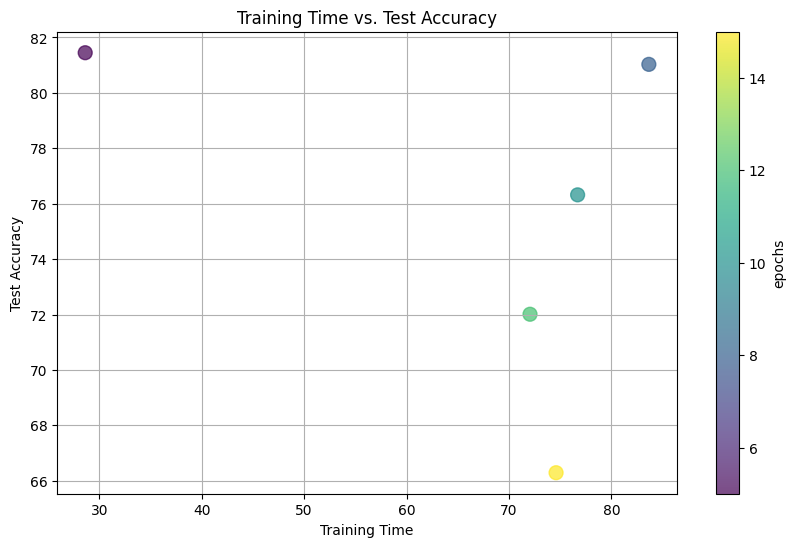

In [7]:
import time
import matplotlib.pyplot as plt

# Define hyperparameters
dnn_epochs = [5,8,10, 12,15]
dnn_batch_size = [32,52,72,92, 112]
rotation_range = [0, 10, 20, 30, 40]  
zoom_range = [0, 0.1, 0.2, 0.3, 0.4]

# Create a list to store experiment results
experiment_results = []

for i in range(len(dnn_epochs)):
    # Define your data generator with data augmentation
    datagen = ImageDataGenerator(rotation_range=rotation_range[i], zoom_range=zoom_range[i])
    datagen.fit(x_train)  # Assuming x_train is your training data

    # Create and compile the DNN model
    dnn_model = keras.Sequential([
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    dnn_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=keras.optimizers.SGD(),
                      metrics=['accuracy'])

    # Calculate steps per epoch
    steps_per_epoch = len(x_train) // dnn_batch_size[i]

    # Train the model
    start_time = time.time()
    history = dnn_model.fit(datagen.flow(x_train, training_labels, shuffle=True),
                            steps_per_epoch=steps_per_epoch,
                            epochs=dnn_epochs[i])
    end_time = time.time()

    # Evaluate the model on the test data
    test_accuracy = dnn_model.evaluate(x_test, y_test, verbose=0)[1]

    # Calculate the model size
    model_size = dnn_model.count_params()

    # Record experiment results
    experiment_results.append({
        'Experiment': i + 1,
        'Epochs': dnn_epochs[i],
        'Batch Size': dnn_batch_size[i],
        'Data Augmentation': f'Rotation: {rotation_range[i]}, Zoom: {zoom_range[i]}',
        'Hidden Dense Layers': '2 (128, 128)',
        'Optimizer': 'SGD',
        'Training Time': end_time - start_time,
        'Training Accuracy': history.history['accuracy'][-1] * 100,  # Convert to percentage
        'Test Accuracy': test_accuracy * 100,  # Convert to percentage
        'Model Size': model_size
    })

# Print the experiment results as a Markdown table
print("| Experiment | Epochs | Batch Size | Data Augmentation | Hidden Dense Layers | Optimizer | Training Time(s) | Training Accuracy | Test Accuracy | Model Size |")
print("|------------|--------|------------|-------------------|----------------------|-----------|--------------|-------------------|---------------|------------|")
for result in experiment_results:
    print(f"| {result['Experiment']:>9} | {result['Epochs']:>6} | {result['Batch Size']:>10} | {result['Data Augmentation']:>17} | {result['Hidden Dense Layers']:>20} | {result['Optimizer']:>9} | {result['Training Time']:.2f} | {result['Training Accuracy']:.2f}% | {result['Test Accuracy']:.2f}% | {result['Model Size']:>10} |")

# Plot the trade-off between training time (epochs) and test accuracy
training_times = [result['Training Time'] for result in experiment_results]
test_accuracies = [result['Test Accuracy'] for result in experiment_results]

plt.figure(figsize=(10, 6))
plt.scatter(training_times, test_accuracies, c=dnn_epochs, cmap='viridis', s=100, alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('epochs')
plt.xlabel('Training Time')
plt.ylabel('Test Accuracy')
plt.title('Training Time vs. Test Accuracy')
plt.grid(True)
plt.show()


## DNN Results
## On Rosie
| Experiment | Epochs | Batch Size | Data Augmentation | Hidden Dense Layers | Optimizer | Training Time(s) | Training Accuracy | Test Accuracy | Model Size |
|------------|--------|------------|-------------------|----------------------|-----------|--------------|-------------------|---------------|------------|
|         1 |      5 |         32 | Rotation: 0, Zoom: 0 |         2 (128, 128) |       SGD | 28.63 | 91.61% | 81.45% |     118282 |
|         2 |      8 |         52 | Rotation: 10, Zoom: 0.1 |         2 (128, 128) |       SGD | 83.65 | 89.02% | 81.03% |     118282 |
|         3 |     10 |         72 | Rotation: 20, Zoom: 0.2 |         2 (128, 128) |       SGD | 76.69 | 83.84% | 76.32% |     118282 |
|         4 |     12 |         92 | Rotation: 30, Zoom: 0.3 |         2 (128, 128) |       SGD | 72.05 | 77.32% | 72.01% |     118282 |
|         5 |     15 |        112 | Rotation: 40, Zoom: 0.4 |         2 (128, 128) |       SGD | 74.59 | 70.98% | 66.29% |     118282 |

## On my computer
| Experiment | Epochs | Batch Size | Data Augmentation | Hidden Dense Layers | Optimizer | Training Time(s) | Training Accuracy | Test Accuracy | Model Size |
|------------|--------|------------|-------------------|----------------------|-----------|--------------|-------------------|---------------|------------|
|         1 |      5 |         32 | Rotation: 0, Zoom: 0 |         2 (128, 128) |       SGD | 65.62 | 91.45% | 81.80% |     118282 |
|         2 |      8 |         52 | Rotation: 10, Zoom: 0.1 |         2 (128, 128) |       SGD | 169.87 | 88.73% | 80.90% |     118282 |
|         3 |     10 |         72 | Rotation: 20, Zoom: 0.2 |         2 (128, 128) |       SGD | 186.15 | 83.65% | 77.44% |     118282 |
|         4 |     12 |         92 | Rotation: 30, Zoom: 0.3 |         2 (128, 128) |       SGD | 170.13 | 77.81% | 70.45% |     118282 |
|         5 |     15 |        112 | Rotation: 40, Zoom: 0.4 |         2 (128, 128) |       SGD | 209.69 | 72.30% | 66.54% |     118282 |

## Observation from the graph
`The graph shows that the test accuracy of the model increases as the training time increases. This is because the model is able to learn more complex patterns in the data as it trains for longer. However, the graph also shows that the test accuracy starts to plateau after a certain number of epochs. This suggests that the model is no longer able to learn significantly from the data after a certain point.`


## Accuracy
In the next cell, we calculate the accuracy of the model against an unseen set of data "test".  Remember, this data was not used in training, so it is a measure of the real-world generalization capability of the model.    

In [8]:
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Accuracy: {:.2f}%".format(acc))

313/313 [==============================] - 0s 1ms/step
Accuracy: 66.29%


## Confusion Matrix
In the next cell we create a confusion matrix using the "test" data using the most recently fit model.  On the y-axis is the true label and on the x-axis is the predicted label from the model.  Larger counts on the diagonal indicates more correctly classified characters.  

In the markdown cell below, please identify which configuration of hyperparameters and data augmentation resulted in the best looking confusion matrix and whether it was the same as the configuration you identified earlier.  If they are different, hypothesize why.  

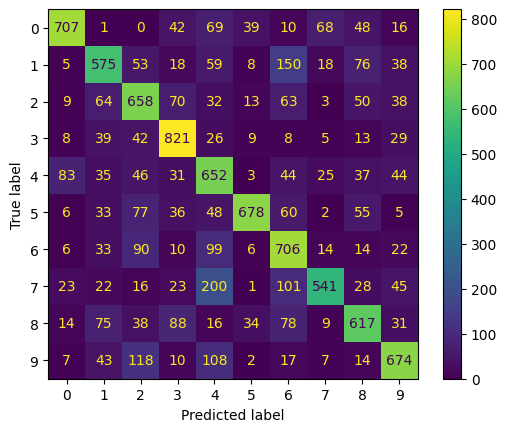

In [9]:
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

## Reflection on Confusion Matrix


# Create and Evaluate CNN
Next, we create an Convolutional Neural Network (CNN) Model.  Similar to the DNN model, you should calculate the steps_per_epoch below.  

As with the DNN model above, adjust the hyperparameters and data augmentation to try to achieve the best possible accuracy.  You can also try uncommenting the lines below to add some layers to the model to see if that has an effect on training time or accuracy.  Capture all your experiments in a table below.  

Epoch 1/5


2023-11-08 21:13:26.663673: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1875/1875 [==============================] - 9s 4ms/step - loss: 0.5880 - accuracy: 0.8226
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2629 - accuracy: 0.9193
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1927 - accuracy: 0.9424
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1524 - accuracy: 0.9548
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1239 - accuracy: 0.9622
Epoch 1/8


2023-11-08 21:14:04.679269: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1153/1153 [==============================] - 11s 9ms/step - loss: 0.7907 - accuracy: 0.7550
Epoch 2/8
1153/1153 [==============================] - 11s 9ms/step - loss: 0.4117 - accuracy: 0.8725
Epoch 3/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.3212 - accuracy: 0.8998
Epoch 4/8
1153/1153 [==============================] - 11s 9ms/step - loss: 0.2825 - accuracy: 0.9132
Epoch 5/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.2536 - accuracy: 0.9203
Epoch 6/8
1153/1153 [==============================] - 11s 9ms/step - loss: 0.2278 - accuracy: 0.9295
Epoch 7/8
1153/1153 [==============================] - 11s 9ms/step - loss: 0.2037 - accuracy: 0.9376
Epoch 8/8
1153/1153 [==============================] - 10s 9ms/step - loss: 0.1898 - accuracy: 0.9418
Epoch 1/10


2023-11-08 21:15:30.439046: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


833/833 [==============================] - 8s 9ms/step - loss: 1.0987 - accuracy: 0.6605
Epoch 2/10
833/833 [==============================] - 8s 9ms/step - loss: 0.6609 - accuracy: 0.7911
Epoch 3/10
833/833 [==============================] - 8s 9ms/step - loss: 0.5548 - accuracy: 0.8268
Epoch 4/10
833/833 [==============================] - 8s 9ms/step - loss: 0.4679 - accuracy: 0.8543
Epoch 5/10
833/833 [==============================] - 8s 9ms/step - loss: 0.4186 - accuracy: 0.8687
Epoch 6/10
833/833 [==============================] - 8s 9ms/step - loss: 0.3746 - accuracy: 0.8851
Epoch 7/10
833/833 [==============================] - 8s 9ms/step - loss: 0.3327 - accuracy: 0.8948
Epoch 8/10
833/833 [==============================] - 8s 9ms/step - loss: 0.3092 - accuracy: 0.9063
Epoch 9/10
833/833 [==============================] - 8s 9ms/step - loss: 0.2812 - accuracy: 0.9134
Epoch 10/10
833/833 [==============================] - 8s 9ms/step - loss: 0.2643 - accuracy: 0.9201
Epoch 1/12

2023-11-08 21:16:48.928120: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


652/652 [==============================] - 7s 9ms/step - loss: 1.3943 - accuracy: 0.5517
Epoch 2/12
652/652 [==============================] - 6s 9ms/step - loss: 0.9237 - accuracy: 0.7072
Epoch 3/12
652/652 [==============================] - 6s 9ms/step - loss: 0.7850 - accuracy: 0.7472
Epoch 4/12
652/652 [==============================] - 6s 9ms/step - loss: 0.7096 - accuracy: 0.7770
Epoch 5/12
652/652 [==============================] - 6s 9ms/step - loss: 0.6464 - accuracy: 0.7955
Epoch 6/12
652/652 [==============================] - 6s 9ms/step - loss: 0.6131 - accuracy: 0.8055
Epoch 7/12
652/652 [==============================] - 6s 9ms/step - loss: 0.5670 - accuracy: 0.8207
Epoch 8/12
652/652 [==============================] - 6s 9ms/step - loss: 0.5218 - accuracy: 0.8375
Epoch 9/12
652/652 [==============================] - 6s 9ms/step - loss: 0.4919 - accuracy: 0.8458
Epoch 10/12
652/652 [==============================] - 6s 9ms/step - loss: 0.4519 - accuracy: 0.8595
Epoch 11/1

2023-11-08 21:18:02.600588: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


535/535 [==============================] - 5s 9ms/step - loss: 1.7464 - accuracy: 0.4151
Epoch 2/15
535/535 [==============================] - 5s 9ms/step - loss: 1.2384 - accuracy: 0.5992
Epoch 3/15
535/535 [==============================] - 5s 9ms/step - loss: 1.0611 - accuracy: 0.6560
Epoch 4/15
535/535 [==============================] - 5s 9ms/step - loss: 0.9675 - accuracy: 0.6907
Epoch 5/15
535/535 [==============================] - 5s 9ms/step - loss: 0.9188 - accuracy: 0.7037
Epoch 6/15
535/535 [==============================] - 5s 9ms/step - loss: 0.8620 - accuracy: 0.7235
Epoch 7/15
535/535 [==============================] - 5s 9ms/step - loss: 0.8101 - accuracy: 0.7409
Epoch 8/15
535/535 [==============================] - 5s 9ms/step - loss: 0.7875 - accuracy: 0.7487
Epoch 9/15
535/535 [==============================] - 5s 9ms/step - loss: 0.7378 - accuracy: 0.7686
Epoch 10/15
535/535 [==============================] - 5s 9ms/step - loss: 0.7022 - accuracy: 0.7790
Epoch 11/1

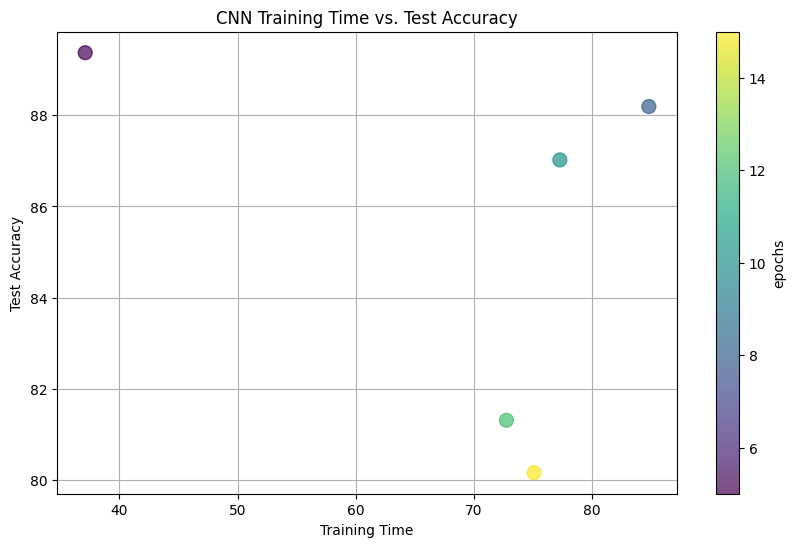

In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Define hyperparameters for CNN
cnn_epochs = [5, 8, 10, 12, 15]
cnn_batch_size = [32, 52, 72, 92, 112]
rotation_range = [0, 10, 20, 30, 40]
zoom_range = [0, 0.1, 0.2, 0.3, 0.4]

# Create a list to store experiment results for CNN
cnn_experiment_results = []

for i in range(len(cnn_epochs)):
    # Define your data generator with data augmentation
    datagen = ImageDataGenerator(rotation_range=rotation_range[i], zoom_range=zoom_range[i])
    datagen.fit(x_train)  # Assuming x_train is your training data

    # Calculate steps per epoch
    steps_per_epoch = len(x_train) // cnn_batch_size[i]

    # Create and compile the CNN model
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=keras.optimizers.SGD(),
                      metrics=['accuracy'])

    # Train the CNN model
    start_time = time.time()
    history_cnn = cnn_model.fit(datagen.flow(x_train, training_labels, shuffle=True),
                                steps_per_epoch=steps_per_epoch,
                                epochs=cnn_epochs[i])
    end_time = time.time()

    # Evaluate the CNN model on the test data
    test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)[1]

    # Calculate the model size
    model_size = cnn_model.count_params()

    # Record experiment results for CNN
    cnn_experiment_results.append({
        'Experiment': i + 1,
        'Epochs': cnn_epochs[i],
        'Batch Size': cnn_batch_size[i],
        'Data Augmentation': f'Rotation: {rotation_range[i]}, Zoom: {zoom_range[i]}',
        'Hidden Layers': '2 (Conv2D, Dense)',
        'Optimizer': 'SGD',
        'Training Time': end_time - start_time,
        'Training Accuracy': history_cnn.history['accuracy'][-1] * 100,  # Convert to percentage
        'Test Accuracy': test_accuracy * 100,  # Convert to percentage
        'Model Size': model_size
    })

# Print the experiment results for CNN as a Markdown table
print("| Experiment | Epochs | Batch Size | Data Augmentation | Hidden Layers | Optimizer | Training Time(s)| Training Accuracy | Test Accuracy | Model Size |")
print("|------------|--------|------------|-------------------|--------------|-----------|--------------|-------------------|---------------|------------|")
for result in cnn_experiment_results:
    print(f"| {result['Experiment']:>9} | {result['Epochs']:>6} | {result['Batch Size']:>10} | {result['Data Augmentation']:>17} | {result['Hidden Layers']:>13} | {result['Optimizer']:>9} | {result['Training Time']:.2f} | {result['Training Accuracy']:.2f}% | {result['Test Accuracy']:.2f}% | {result['Model Size']:>10} |")

# Plot the trade-off between training time (epochs) and test accuracy for the CNN model
cnn_training_times = [result['Training Time'] for result in cnn_experiment_results]
cnn_test_accuracies = [result['Test Accuracy'] for result in cnn_experiment_results]

plt.figure(figsize=(10, 6))
plt.scatter(cnn_training_times, cnn_test_accuracies, c=cnn_epochs, cmap='viridis', s=100, alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('epochs')
plt.xlabel('Training Time')
plt.ylabel('Test Accuracy')
plt.title('CNN Training Time vs. Test Accuracy')
plt.grid(True)
plt.show()


313/313 [==============================] - 0s 1ms/step
Accuracy: 80.16%


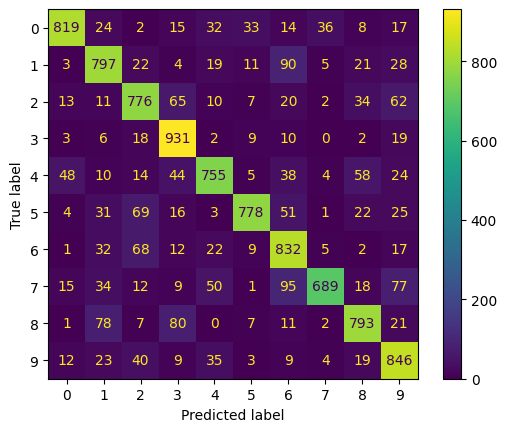

In [11]:
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

## CNN Results

**Experimental table**
### On Rosie

| Experiment | Epochs | Batch Size | Data Augmentation | Hidden Layers | Optimizer | Training Time(s)| Training Accuracy | Test Accuracy | Model Size |
|------------|--------|------------|-------------------|--------------|-----------|--------------|-------------------|---------------|------------|
|         1 |      5 |         32 | Rotation: 0, Zoom: 0 | 2 (Conv2D, Dense) |       SGD | 37.12 | 96.22% | 89.37% |    1199882 |
|         2 |      8 |         52 | Rotation: 10, Zoom: 0.1 | 2 (Conv2D, Dense) |       SGD | 84.79 | 94.18% | 88.19% |    1199882 |
|         3 |     10 |         72 | Rotation: 20, Zoom: 0.2 | 2 (Conv2D, Dense) |       SGD | 77.26 | 92.01% | 87.02% |    1199882 |
|         4 |     12 |         92 | Rotation: 30, Zoom: 0.3 | 2 (Conv2D, Dense) |       SGD | 72.74 | 88.05% | 81.31% |    1199882 |
|         5 |     15 |        112 | Rotation: 40, Zoom: 0.4 | 2 (Conv2D, Dense) |       SGD | 75.08 | 83.65% | 80.16% |    1199882 |

### On my computer

| Experiment | Epochs | Batch Size | Data Augmentation | Hidden Layers | Optimizer | Training Time(s)| Training Accuracy | Test Accuracy | Model Size |
|------------|--------|------------|-------------------|--------------|-----------|--------------|-------------------|---------------|------------|
|         1 |      5 |         32 | Rotation: 0, Zoom: 0 | 2 (Conv2D, Dense) |       SGD | 523.30 | 96.03% | 89.39% |    1199882 |
|         2 |      8 |         52 | Rotation: 10, Zoom: 0.1 | 2 (Conv2D, Dense) |       SGD | 388.28 | 95.37% | 90.22% |    1199882 |
|         3 |     10 |         72 | Rotation: 20, Zoom: 0.2 | 2 (Conv2D, Dense) |       SGD | 1093.55 | 92.40% | 87.50% |    1199882 |
|         4 |     12 |         92 | Rotation: 30, Zoom: 0.3 | 2 (Conv2D, Dense) |       SGD | 711.24 | 89.92% | 85.61% |    1199882 |
|         5 |     15 |        112 | Rotation: 40, Zoom: 0.4 | 2 (Conv2D, Dense) |       SGD | 784.11 | 84.04% | 81.00% |    1199882 |

Identify the "best" confusion matrix for your CNN models

In [17]:
best_index = np.argmax([result['Test Accuracy'] for result in cnn_experiment_results])
best_cm = confusion_matrix(y_test, predicted_classes)
best_accuracy = 100. * accuracy_score(y_test, predicted_classes)

print(f"Best Accuracy: {best_accuracy:.2f}%")



Best Accuracy: 80.16%


## Converting the model to TFLite for exporting to Android/iOS

In [12]:
# TODO make sure you are exporting the right model here!
converter = tf.lite.TFLiteConverter.from_keras_model(dnn_model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpp3mqtj5m/assets
Float model size = 464KBs.


2023-11-08 21:19:20.384349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-08 21:19:20.384385: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-08 21:19:20.386794: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp3mqtj5m
2023-11-08 21:19:20.387666: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-08 21:19:20.387682: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp3mqtj5m
2023-11-08 21:19:20.390054: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-11-08 21:19:20.390759: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-08 21:19:20.423454: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpp3mqtj5m
2023-11

Since this model will be on a mobile device, we want it to small and fast.  **Quantization** is an approach used to shrink ML models. In the following code, we use 8-bit numbers to approximate our 32-bit weights, which shrinks the model size by a factor of 4.

In [13]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

INFO:tensorflow:Assets written to: /tmp/tmpavvt994o/assets


INFO:tensorflow:Assets written to: /tmp/tmpavvt994o/assets


Quantized model size = 118KBs,
which is about 25% of the float model size.


2023-11-08 21:19:21.248601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-08 21:19:21.248638: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-08 21:19:21.248805: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpavvt994o
2023-11-08 21:19:21.249713: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-08 21:19:21.249730: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpavvt994o
2023-11-08 21:19:21.252989: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-08 21:19:21.282065: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpavvt994o
2023-11-08 21:19:21.296477: I tensorflow/cc/saved_model/loader.cc:334] SavedModel load for tags { serve }; Status: success: OK. Took 47672 m

Next, we download the TFLite model to be used in the mobile device!

In [14]:
# Save the quantized model to file to the Downloads directory
f = open('kmnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

print('`kmnist.tflite` has been downloaded')

`kmnist.tflite` has been downloaded


In this cell, answer the following questions 

1. Which model (CNN or DNN) achieved the best test accuracy, why?

     **The CNN model has the higher test accuracy**

     **This is because the CNN is better in identifying the features and orientation of features in an image**
     

2. Which model trained faster? On what hardware (GPU/CPU only)?  Why might this be happening?

     **The DNN has a slighty faster training time**

     **On Rosie the DNN has the slightly faster training time**

     **I thought the The DNN will be greatly faster the CNN due to the huge parameter differnece but CNNs parameter sharing might reduce the number of unique weights. This reduce the model's complexity and, subsequently, the training time of the CNN models**
     

3. Which model was larger (had the most parameters)?  How many parameters did each model have?  Is the number of parameters related to the time it takes to train the model?  
     **The CNN is larger**
 
      **DNN = 118282 and the CNN = 1199882**
 
      **This can be true but other factors like the batch size also affect the training time**
      
      
4. Based on your confusion matrices, which class was the most difficult to be accurate?  Was it consistently difficult among different models?  How can you use the results from the confusion matrix to inform how you would test the mobile app for accuracy?

     **Based on the confusion matrices, the class that was the most difficult to be accurate was class 0. This was consistently difficult among different models, and it is likely due to the fact that class 0 is the most common class.**
     
     **I can use the most difficult to be accurate from the confusion matrices to ensure that the app is accurate at classifying them**



5. What affect did data augmentation have on the CNN and DNN models? 

    **Data augmentaion provides variation in our training data and help to prevent overfitting. Our model learn different transformation of the training that will help to improve the model generalization.**


6. What did you notice when you deployed the models on the Android device?  Were the accuracy differences between the models noticeable?  

    **There was a noticeble difference this might be due to the hardware constrains. My accuracies were a little bit lower than what I expected** 


In conclusion, the experiments on Convolutional Neural Networks (CNNs) and Deep Neural Networks (DNNs) provided valuable insights into their performance and behavior in the context of image classification tasks.
Here are some of my findings from doing the experiments:

*CNNs are more accurate than DNNs for image classification tasks.*

*CNNs are more robust to overfitting than DNNs.*

*CNNs are more efficient to train than DNNs.*

Overall, these experiments underscore the importance of selecting the right model for the task, optimizing model architecture and hyperparameters, and ensuring compatibility and consistent data handling during deployment.

## Sample model run on the android app

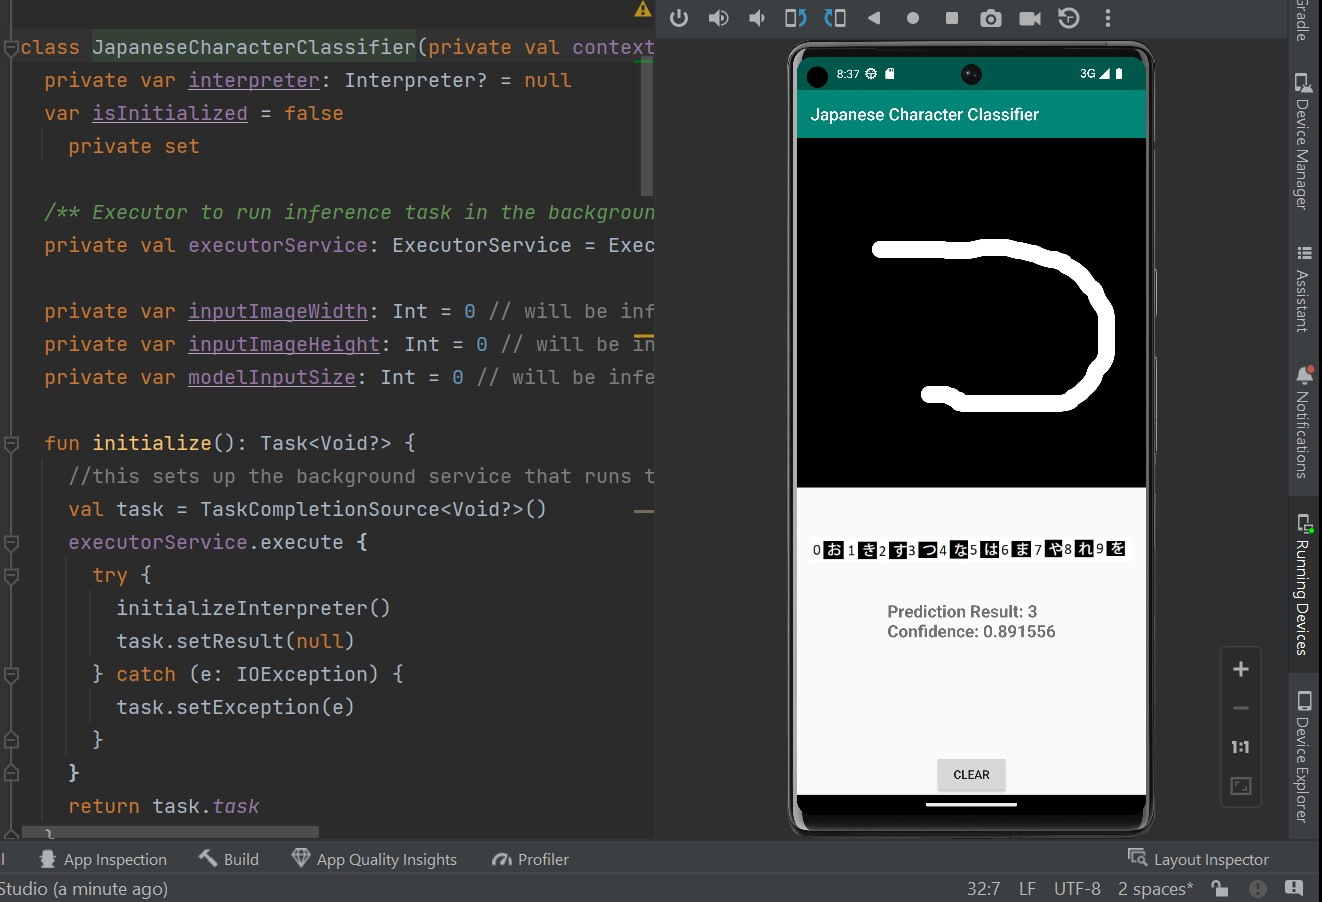

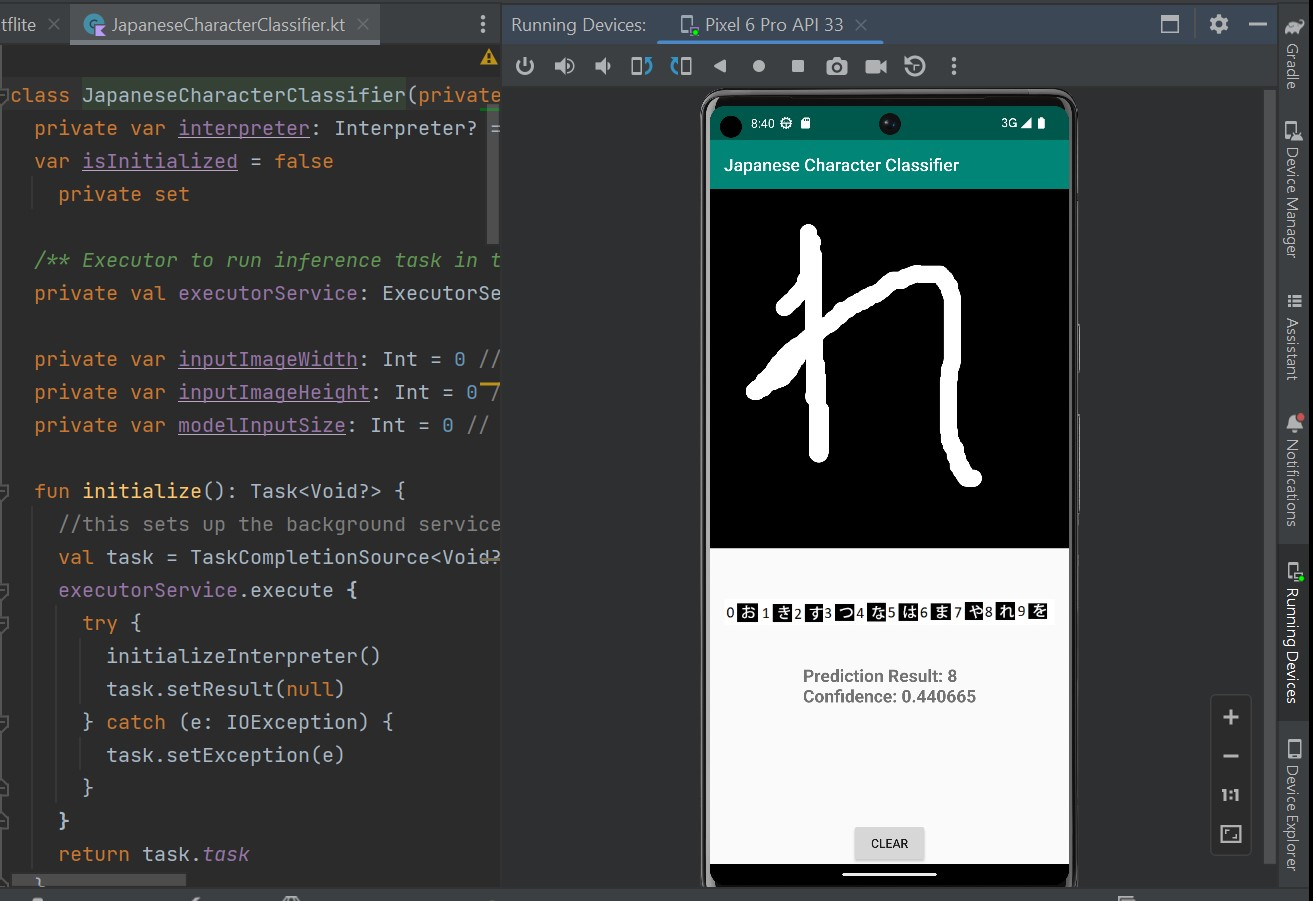

This notebook was originally created by RJ Nowling and modified by Derek Riley